In [52]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [53]:
df0=pd.read_csv('C:/Users/NAVAMSHU RAM/Downloads/covid_19_india.csv',parse_dates=['Date'],dayfirst=True)

In [54]:
#Obtaining df0 = pd.read_csv("covid_19_india.csv")
df0['Active'] = df0['Confirmed'] - df0['Cured'] - df0['Deaths']
df0.tail() 
df0 = df0.drop(['Sno','ConfirmedIndianNational', 'ConfirmedForeignNational','Cured','Deaths'], axis=1)
df0.head()
print(df0)

            Date     Time State/UnionTerritory  Confirmed  Active
0     2020-01-30  6:00 PM               Kerala        1.0     1.0
1     2020-01-31  6:00 PM               Kerala        1.0     1.0
2     2020-02-01  6:00 PM               Kerala        2.0     2.0
3     2020-02-02  6:00 PM               Kerala        3.0     3.0
4     2020-02-03  6:00 PM               Kerala        3.0     3.0
...          ...      ...                  ...        ...     ...
18105        NaT      NaN                  NaN        NaN     NaN
18106        NaT      NaN                  NaN        NaN     NaN
18107        NaT      NaN                  NaN        NaN     NaN
18108        NaT      NaN                  NaN        NaN     NaN
18109        NaT      NaN                  NaN        NaN     NaN

[18110 rows x 5 columns]


                Cases
Date                 
2020-01-30        1.0
2020-01-31        1.0
2020-02-01        2.0
2020-02-02        3.0
2020-02-03        3.0
...               ...
2021-06-04  1635993.0
2021-06-05  1555248.0
2021-06-06  1477799.0
2021-06-07  1401609.0
2021-06-08  1276816.0

[496 rows x 1 columns]


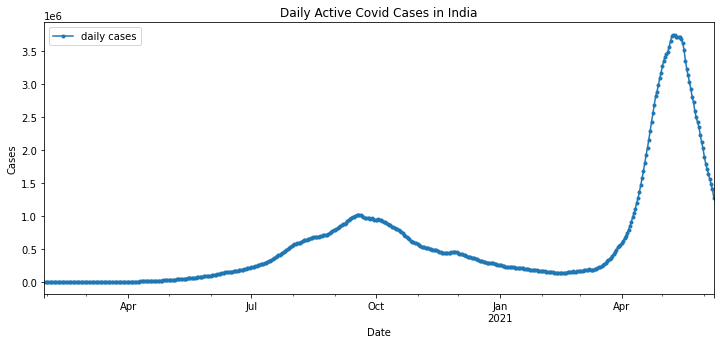

In [55]:
count = []
for i in range(1,len(df0)):
    count.append(sum(pd.to_numeric(df0.iloc[i,4:].values)))

#Grouping the datewise active cases
df = pd.DataFrame()
df["Date"] = df0.Date
df.Date = pd.to_datetime(df0.Date)
df["Cases"] = df0["Active"]
df.sort_values(by="Date")
df1=df.groupby(["Date"]).sum()
print(df1)

df1.Cases.plot(title="Daily Active Covid Cases in India",marker=".",figsize=(12,5),label="daily cases")
plt.ylabel("Cases")
plt.legend()
plt.show()


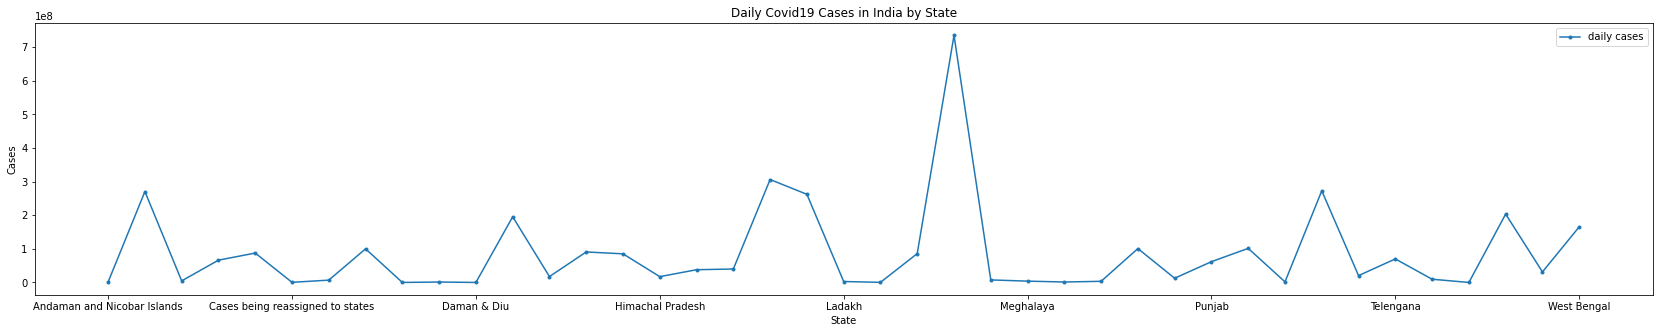

In [56]:
#Active cases in India statewise
df2 = pd.DataFrame({"State":[],"Cases":[]})
df2["State"]=df0["State/UnionTerritory"][1:]
df2["Cases"]=df0["Confirmed"]
df2= df2.set_index("State")
df3=df2.groupby("State").sum()

df3.Cases.plot(title="Daily Covid19 Cases in India by State",marker=".",figsize=(29,5),label="daily cases")
plt.ylabel("Cases")
plt.legend()
plt.show()

In [57]:
#Statewise active cases in India grouped by dates
df4 = pd.DataFrame()
df4["Date"] = df0["Date"][1:]
df4["Date"] = pd.to_datetime(df0["Date"])
df4["Cases"] =df0["Active"]
df4["State"] = df0["State/UnionTerritory"][1:]
df5=df4.groupby(["Date","State"]).sum()
print(df5)

                             Cases
Date       State                  
2020-01-31 Kerala              1.0
2020-02-01 Kerala              2.0
2020-02-02 Kerala              3.0
2020-02-03 Kerala              3.0
2020-02-04 Kerala              3.0
...                            ...
2021-06-08 Tamil Nadu     232026.0
           Telangana       25406.0
           Tripura          6018.0
           Uttar Pradesh   15681.0
           Uttarakhand     14122.0

[15804 rows x 1 columns]


In [58]:
# normalize the dataset
dataset=[]
for i in range(1,len(df1)):
  dataset.append(pd.to_numeric(df1.iloc[i,:1].values))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [59]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

346 149


In [60]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
 

# reshape train and test sets into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1 ))

In [61]:
# create and fit the LSTM network
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 45, return_sequences = True, input_shape = (trainX.shape[1], 1)))
#model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 45))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY,validation_data=(testX,testY), epochs=500, batch_size=150,verbose=1)

Epoch 1/500
3/3 [==============================] - 2s 248ms/step - loss: 0.0151 - val_loss: 0.2064
Epoch 2/500
3/3 [==============================] - 0s 14ms/step - loss: 0.0134 - val_loss: 0.1974
Epoch 3/500
3/3 [==============================] - 0s 11ms/step - loss: 0.0118 - val_loss: 0.1885
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0103 - val_loss: 0.1796
Epoch 5/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0090 - val_loss: 0.1706
Epoch 6/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0080 - val_loss: 0.1616
Epoch 7/500
3/3 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.1528
Epoch 8/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.1443
Epoch 9/500
3/3 [==============================] - 0s 11ms/step - loss: 0.0062 - val_loss: 0.1365
Epoch 10/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.1297
Epoch 11/500
3/3 [==

Epoch 82/500
3/3 [==============================] - 0s 10ms/step - loss: 6.3672e-06 - val_loss: 0.0024
Epoch 83/500
3/3 [==============================] - 0s 10ms/step - loss: 6.5012e-06 - val_loss: 0.0023
Epoch 84/500
3/3 [==============================] - 0s 10ms/step - loss: 6.3633e-06 - val_loss: 0.0024
Epoch 85/500
3/3 [==============================] - 0s 9ms/step - loss: 6.6164e-06 - val_loss: 0.0023
Epoch 86/500
3/3 [==============================] - 0s 10ms/step - loss: 6.3996e-06 - val_loss: 0.0023
Epoch 87/500
3/3 [==============================] - 0s 10ms/step - loss: 6.6571e-06 - val_loss: 0.0023
Epoch 88/500
3/3 [==============================] - 0s 10ms/step - loss: 6.3816e-06 - val_loss: 0.0023
Epoch 89/500
3/3 [==============================] - 0s 10ms/step - loss: 6.5511e-06 - val_loss: 0.0022
Epoch 90/500
3/3 [==============================] - 0s 9ms/step - loss: 6.4930e-06 - val_loss: 0.0022
Epoch 91/500
3/3 [==============================] - 0s 10ms/step - loss: 6.

3/3 [==============================] - 0s 10ms/step - loss: 5.8926e-06 - val_loss: 0.0015
Epoch 162/500
3/3 [==============================] - 0s 10ms/step - loss: 5.8450e-06 - val_loss: 0.0015
Epoch 163/500
3/3 [==============================] - 0s 10ms/step - loss: 5.8585e-06 - val_loss: 0.0015
Epoch 164/500
3/3 [==============================] - 0s 11ms/step - loss: 5.8553e-06 - val_loss: 0.0015
Epoch 165/500
3/3 [==============================] - 0s 10ms/step - loss: 5.9635e-06 - val_loss: 0.0015
Epoch 166/500
3/3 [==============================] - 0s 10ms/step - loss: 5.8072e-06 - val_loss: 0.0015
Epoch 167/500
3/3 [==============================] - 0s 10ms/step - loss: 5.9774e-06 - val_loss: 0.0015
Epoch 168/500
3/3 [==============================] - 0s 10ms/step - loss: 5.8527e-06 - val_loss: 0.0014
Epoch 169/500
3/3 [==============================] - 0s 10ms/step - loss: 5.8448e-06 - val_loss: 0.0014
Epoch 170/500
3/3 [==============================] - 0s 11ms/step - loss: 5.85

3/3 [==============================] - 0s 10ms/step - loss: 5.5874e-06 - val_loss: 8.6101e-04
Epoch 240/500
3/3 [==============================] - 0s 9ms/step - loss: 5.6910e-06 - val_loss: 8.5450e-04
Epoch 241/500
3/3 [==============================] - 0s 10ms/step - loss: 5.3912e-06 - val_loss: 8.8205e-04
Epoch 242/500
3/3 [==============================] - 0s 10ms/step - loss: 5.7430e-06 - val_loss: 8.4374e-04
Epoch 243/500
3/3 [==============================] - 0s 10ms/step - loss: 5.7733e-06 - val_loss: 8.4520e-04
Epoch 244/500
3/3 [==============================] - 0s 9ms/step - loss: 5.4832e-06 - val_loss: 8.5939e-04
Epoch 245/500
3/3 [==============================] - 0s 10ms/step - loss: 5.5306e-06 - val_loss: 8.2154e-04
Epoch 246/500
3/3 [==============================] - 0s 9ms/step - loss: 5.4218e-06 - val_loss: 8.4001e-04
Epoch 247/500
3/3 [==============================] - 0s 10ms/step - loss: 5.4743e-06 - val_loss: 8.2897e-04
Epoch 248/500
3/3 [==========================

3/3 [==============================] - 0s 10ms/step - loss: 5.0683e-06 - val_loss: 5.0954e-04
Epoch 316/500
3/3 [==============================] - 0s 10ms/step - loss: 5.1227e-06 - val_loss: 5.0477e-04
Epoch 317/500
3/3 [==============================] - 0s 10ms/step - loss: 5.0805e-06 - val_loss: 4.9084e-04
Epoch 318/500
3/3 [==============================] - 0s 10ms/step - loss: 5.1753e-06 - val_loss: 4.7636e-04
Epoch 319/500
3/3 [==============================] - 0s 10ms/step - loss: 5.0348e-06 - val_loss: 4.7599e-04
Epoch 320/500
3/3 [==============================] - 0s 10ms/step - loss: 5.0753e-06 - val_loss: 4.6230e-04
Epoch 321/500
3/3 [==============================] - 0s 9ms/step - loss: 5.0908e-06 - val_loss: 4.6796e-04
Epoch 322/500
3/3 [==============================] - 0s 10ms/step - loss: 5.1259e-06 - val_loss: 4.6350e-04
Epoch 323/500
3/3 [==============================] - 0s 9ms/step - loss: 4.9968e-06 - val_loss: 4.5982e-04
Epoch 324/500
3/3 [=========================

3/3 [==============================] - 0s 10ms/step - loss: 5.1860e-06 - val_loss: 3.2241e-04
Epoch 392/500
3/3 [==============================] - 0s 10ms/step - loss: 5.1548e-06 - val_loss: 3.2365e-04
Epoch 393/500
3/3 [==============================] - 0s 10ms/step - loss: 4.9567e-06 - val_loss: 3.1916e-04
Epoch 394/500
3/3 [==============================] - 0s 10ms/step - loss: 4.9668e-06 - val_loss: 3.2578e-04
Epoch 395/500
3/3 [==============================] - 0s 10ms/step - loss: 5.0044e-06 - val_loss: 3.1823e-04
Epoch 396/500
3/3 [==============================] - 0s 10ms/step - loss: 4.8755e-06 - val_loss: 3.1972e-04
Epoch 397/500
3/3 [==============================] - 0s 10ms/step - loss: 5.0331e-06 - val_loss: 3.1367e-04
Epoch 398/500
3/3 [==============================] - 0s 10ms/step - loss: 4.8916e-06 - val_loss: 3.0906e-04
Epoch 399/500
3/3 [==============================] - 0s 9ms/step - loss: 4.7971e-06 - val_loss: 3.0708e-04
Epoch 400/500
3/3 [========================

3/3 [==============================] - 0s 10ms/step - loss: 4.8035e-06 - val_loss: 2.7470e-04
Epoch 468/500
3/3 [==============================] - 0s 9ms/step - loss: 4.7074e-06 - val_loss: 2.7570e-04
Epoch 469/500
3/3 [==============================] - 0s 10ms/step - loss: 4.7149e-06 - val_loss: 2.7630e-04
Epoch 470/500
3/3 [==============================] - 0s 10ms/step - loss: 4.9004e-06 - val_loss: 2.7536e-04
Epoch 471/500
3/3 [==============================] - 0s 10ms/step - loss: 4.6899e-06 - val_loss: 2.7529e-04
Epoch 472/500
3/3 [==============================] - 0s 10ms/step - loss: 4.6919e-06 - val_loss: 2.7524e-04
Epoch 473/500
3/3 [==============================] - 0s 9ms/step - loss: 4.6814e-06 - val_loss: 2.7504e-04
Epoch 474/500
3/3 [==============================] - 0s 9ms/step - loss: 4.6601e-06 - val_loss: 2.7649e-04
Epoch 475/500
3/3 [==============================] - 0s 10ms/step - loss: 4.8072e-06 - val_loss: 2.7452e-04
Epoch 476/500
3/3 [==========================

In [62]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('r2 score:',r2_score(testY[0], testPredict[:,0]))

Train Score: 8078.39 RMSE
Test Score: 62652.26 RMSE
r2 score: 0.9975505960532509


In [63]:
df6=pd.DataFrame({'Actual':testY.reshape(-1),'predicted':testPredict.reshape(-1)})
print(df6)

        Actual     predicted
0     216558.0  2.231130e+05
1     214507.0  2.171830e+05
2     213603.0  2.151453e+05
3     213027.0  2.142472e+05
4     211033.0  2.136750e+05
..         ...           ...
143  1635993.0  1.719731e+06
144  1555248.0  1.641942e+06
145  1477799.0  1.560747e+06
146  1401609.0  1.482817e+06
147  1276816.0  1.406117e+06

[148 rows x 2 columns]


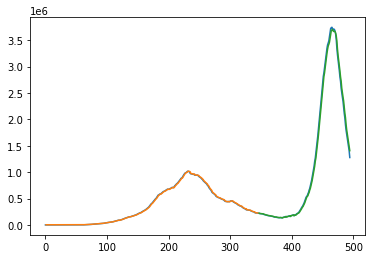

In [64]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [65]:
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))
testX=scaler.inverse_transform(testX)
print(testX)

[[ 222526.]
 [ 216558.]
 [ 214507.]
 [ 213603.]
 [ 213027.]
 [ 211033.]
 [ 208826.]
 [ 208012.]
 [ 200528.]
 [ 197201.]
 [ 192308.]
 [ 188688.]
 [ 185662.]
 [ 184408.]
 [ 178627.]
 [ 177266.]
 [ 176498.]
 [ 173740.]
 [ 171686.]
 [ 169824.]
 [ 168784.]
 [ 167256.]
 [ 163353.]
 [ 160057.]
 [ 155025.]
 [ 151460.]
 [ 148590.]
 [ 148766.]
 [ 148609.]
 [ 143625.]
 [ 141511.]
 [ 138735.]
 [ 135926.]
 [ 136571.]
 [ 137567.]
 [ 139637.]
 [ 136872.]
 [ 136549.]
 [ 131620.]
 [ 139542.]
 [ 143127.]
 [ 145634.]
 [ 150055.]
 [ 147306.]
 [ 159379.]
 [ 151708.]
 [ 155986.]
 [ 159590.]
 [ 164511.]
 [ 167535.]
 [ 168358.]
 [ 159215.]
 [ 173413.]
 [ 176319.]
 [ 180304.]
 [ 184523.]
 [ 188747.]
 [ 173548.]
 [ 184598.]
 [ 184598.]
 [ 189226.]
 [ 202022.]
 [ 210544.]
 [ 219262.]
 [ 223432.]
 [ 234406.]
 [ 252364.]
 [ 271282.]
 [ 288394.]
 [ 309087.]
 [ 334646.]
 [ 345377.]
 [ 368457.]
 [ 395192.]
 [ 421066.]
 [ 452647.]
 [ 486310.]
 [ 521808.]
 [ 540720.]
 [ 552566.]
 [ 588531.]
 [ 614696.]
 [ 658909.]
 [ 6

In [66]:
x_input=testX[147:]
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [67]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[3.6555479]
2
1 day input [3.65554786]
1 day output [[2.6123817]]
2 day input [2.6123817]
2 day output [[2.1686158]]
3 day input [2.16861582]
3 day output [[1.91117]]
4 day input [1.91117001]
4 day output [[1.7389926]]
5 day input [1.73899257]
5 day output [[1.6139398]]
6 day input [1.61393976]
6 day output [[1.5180718]]
7 day input [1.51807177]
7 day output [[1.4417193]]
8 day input [1.44171929]
8 day output [[1.3791584]]
9 day input [1.37915838]
9 day output [[1.3267605]]
10 day input [1.32676053]
10 day output [[1.2821012]]
11 day input [1.28210115]
11 day output [[1.2434916]]
12 day input [1.24349165]
12 day output [[1.2097158]]
13 day input [1.20971584]
13 day output [[1.1798723]]
14 day input [1.17987227]
14 day output [[1.153278]]
15 day input [1.15327799]
15 day output [[1.1294041]]
16 day input [1.12940407]
16 day output [[1.1078342]]
17 day input [1.10783422]
17 day output [[1.0882357]]
18 day input [1.08823574]
18 day output [[1.0703387]]
19 day input [1.07033873]
19 day out

In [68]:
#Forecast of active cases for the next 30 days
df6 = pd.DataFrame()
df6["Date"]=['09-06-2021','10-06-2021','11-06-2021','12-06-2021','13-06-2021','14-06-2021',
             '15-06-2021','16-06-2021','17-06-2021','18-06-2021','19-06-2021','20-06-2021',
             '21-06-2021','22-06-2021','23-06-2021','24-06-2021','25-06-2021','26-06-2021',
             '27-06-2021','28-06-2021','29-06-2021','30-06-2021','01-07-2021','02-07-2021',
             '03-07-2021','04-07-2021','05-07-2021','06-07-2021','07-07-2021','08-07-2021']
df6["Cases for next 30 days"] = scaler.inverse_transform(lst_output)
print(df6)

          Date  Cases for next 30 days
0   09-06-2021            1.369089e+07
1   10-06-2021            9.783987e+06
2   11-06-2021            8.121979e+06
3   12-06-2021            7.157784e+06
4   13-06-2021            6.512939e+06
5   14-06-2021            6.044586e+06
6   15-06-2021            5.685538e+06
7   16-06-2021            5.399580e+06
8   17-06-2021            5.165275e+06
9   18-06-2021            4.969032e+06
10  19-06-2021            4.801772e+06
11  20-06-2021            4.657171e+06
12  21-06-2021            4.530672e+06
13  22-06-2021            4.418901e+06
14  23-06-2021            4.319299e+06
15  24-06-2021            4.229886e+06
16  25-06-2021            4.149102e+06
17  26-06-2021            4.075701e+06
18  27-06-2021            4.008672e+06
19  28-06-2021            3.947190e+06
20  29-06-2021            3.890568e+06
21  30-06-2021            3.838233e+06
22  01-07-2021            3.789700e+06
23  02-07-2021            3.744561e+06
24  03-07-2021           